In [33]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FuncFormatter
import seaborn as sns

from Run import Run

runs_dir = "runs-csv"

def empty_run():
    return pd.DataFrame({
        "task": [],
        "learning_rate": [],
        "momentum": [],
        "batch_size": [],
        "delay": [],
        "test_acc": []
    })

epochs = 90

frames = [empty_run() for _ in range(epochs)]

for run_name in sorted(os.listdir(runs_dir)):
    run = Run.from_filename(run_name)
    
    with open(os.path.join(runs_dir, run_name, "test_accuracy"), "r") as test_file:    
        for line in test_file:
            epoch, acc = line.split(",")
            epoch, acc = int(epoch), float(acc) / 100
            
            if (epoch <= epochs):
                frames[epoch - 1] = frames[epoch - 1].append({
                    'task': run.task,
                    'learning_rate': run.learning_rate,
                    'momentum': run.momentum,
                    'batch_size': run.batch_size,
                    'delay': run.delay,
                    'test_acc': acc
                    },
                    ignore_index=True)
            

In [34]:
# runs_df.to_csv('runs_df.csv', index=False)

In [35]:
def discrete_cmap(N, base_cmap=None, b=10):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.logspace(0, 1, N, base=b) / b)
#     color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [46]:
def plot_heatmap(heatmap_df, save_name=None):

    num_plots = len(heatmap_df.delay.unique()) + len(heatmap_df.momentum.unique())
    fig, ax = plt.subplots(figsize=(num_plots * 13, 10), ncols=num_plots, nrows=1)
    if not (isinstance(ax, list) or isinstance(ax, np.ndarray)):
        ax = [ax]
    plt.suptitle("Test accuracy after {} epochs".format(epochs))

    left   =  0.125  # the left side of the subplots of the figure
    right  =  0.9    # the right side of the subplots of the figure
    bottom =  0.1    # the bottom of the subplots of the figure
    top    =  0.9    # the top of the subplots of the figure
    wspace =  0.1    # the amount of width reserved for blank space between subplots
    hspace =  1.1    # the amount of height reserved for white space between subplots

    # This function actually adjusts the sub plots using the above paramters
    plt.subplots_adjust(
        left    =  left, 
        bottom  =  bottom, 
        right   =  right, 
        top     =  top, 
        wspace  =  wspace, 
        hspace  =  hspace
    )

    ax_idx = 0

    for delay in heatmap_df.delay.unique():
        for momentum in heatmap_df.momentum.unique():

            selected_df = heatmap_df[(heatmap_df["delay"] == delay) & (heatmap_df["momentum"] == momentum)]
            selected_df["learning_rate"] = selected_df["learning_rate"].map(lambda lr: "{:.6f}".format(lr))

            pivoted = selected_df.pivot(index="learning_rate", columns="batch_size", values="test_acc")

            ax[ax_idx].set_title("{} batch delay, mom = {}".format(delay, momentum))
            sns.heatmap(pivoted, annot=True, cmap=discrete_cmap(999, "YlGn", 5), fmt=".3f", ax=ax[ax_idx], vmin=0, vmax=1)
#             if ax_idx != 0:
#                 ax[ax_idx].get_yaxis().set_visible(False)

            ax_idx += 1
    
    if save_name is not None:
        plt.savefig(save_name)
        plt.close()

/home/anand/dev/pytorch-venv/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


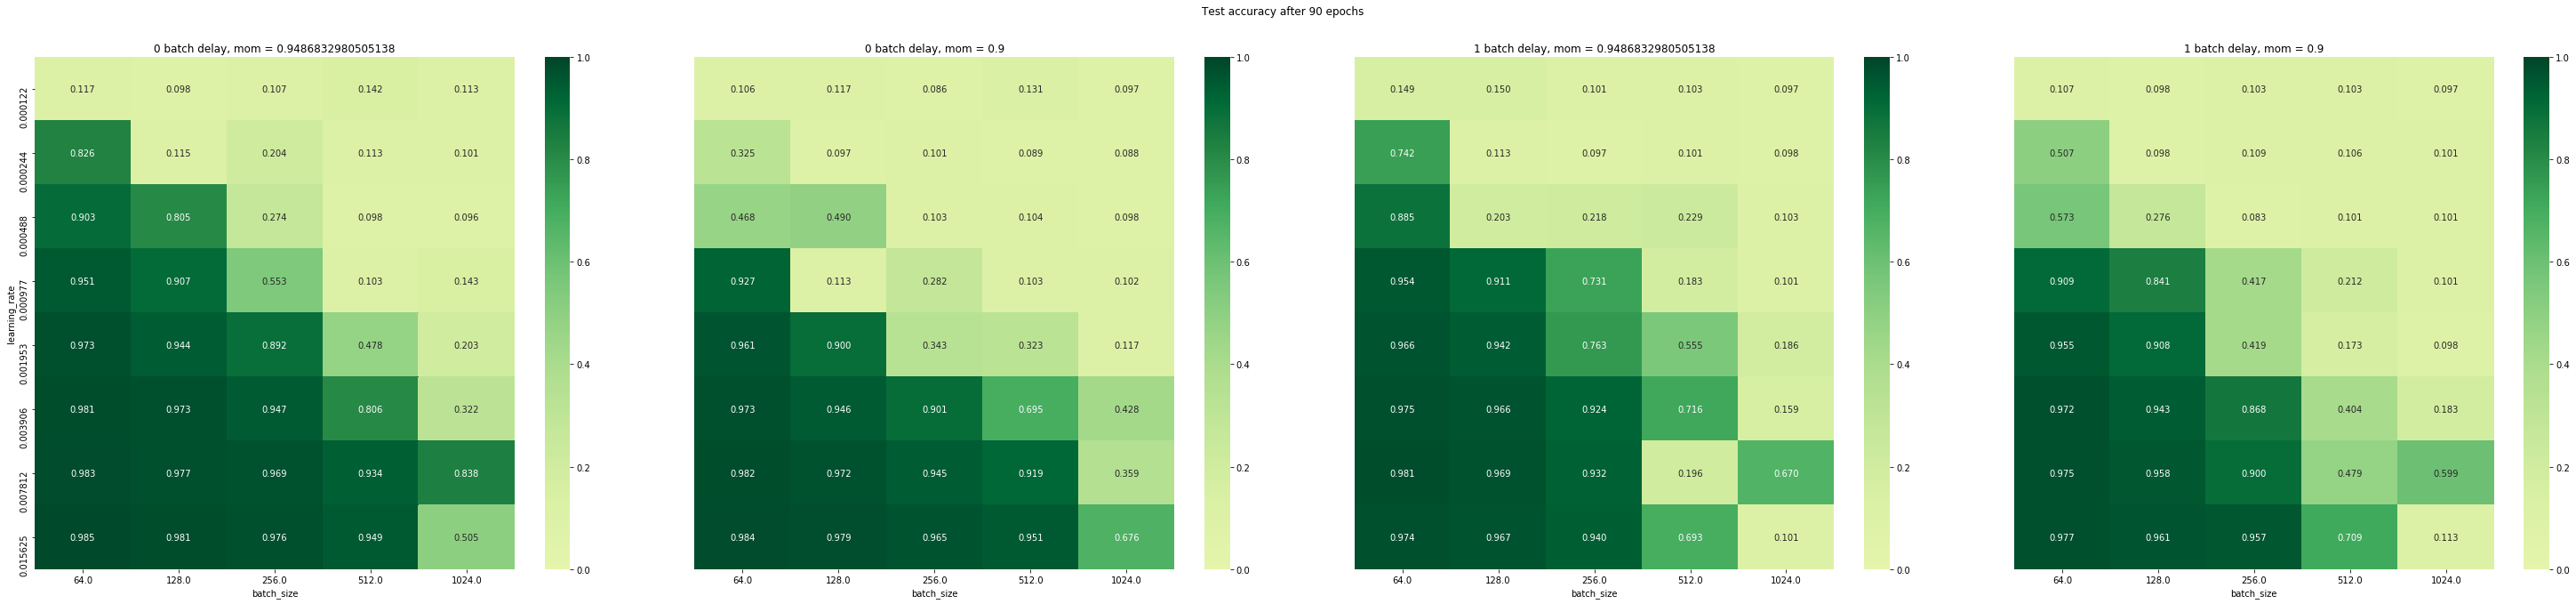

In [43]:
plot_heatmap(frames[2])

In [44]:
import os
import shutil

frames_dir = 'frames'
if os.path.exists(frames_dir):
    shutil.rmtree(frames_dir)
os.makedirs(frames_dir)

for (i, frame) in enumerate(frames):
    plot_heatmap(frame, save_name='frames/{}.png'.format(i))

/home/anand/dev/pytorch-venv/lib/python3.5/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
import subprocess

framerate = 5
out_file = 'out'

cmd = "ffmpeg -y -framerate {} -i {}/%d.png -c:v libx264 -pix_fmt yuv420p {}.mp4"
cmd = cmd.format(framerate, frames_dir, out_file)

subprocess.call(cmd, shell=True)

0